# Implementation of FLAME2 (Woolrich et al. 2004) in Numpyro

June 8th 2022, Lea Waller

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

np.set_printoptions(linewidth=1e6)

In [10]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import BarkerMH, MCMC, NUTS, Predictive, SA

In [11]:
device = "cpu"
num_chains = 16

numpyro.enable_x64()
numpyro.set_platform(device)
numpyro.set_host_device_count(num_chains)

In [12]:
import jax
from jax import random
import jax.numpy as jnp
from jax.scipy.special import expit

In [13]:
import arviz as az

In [14]:
jax.local_device_count()

16

In [15]:
data_frame = pd.read_table("example_data.tsv")

In [16]:
def model_intercept_only(sample_effect_estimate, sample_effect_variance, sample_degrees_of_freedom):
    m = len(sample_effect_estimate)  # i

    coefficients = numpyro.sample(
        "coefficients", 
        dist.Normal(loc=0, scale=1e4).mask(False),
    )
    with numpyro.plate("plate_i", m):
        numpyro.factor(
            "likelihood", 
            dist.StudentT(
                df=sample_degrees_of_freedom, 
                loc=sample_effect_estimate, 
                scale=jnp.sqrt(sample_effect_variance),
            ).log_prob(coefficients)
        )

In [17]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

norm = data_frame.intercept_coefficient.std()
effect = data_frame.intercept_coefficient.values / norm
effect_variance = data_frame.intercept_coefficient_variance.values / np.square(norm)

model_kwargs = dict(
    sample_effect_estimate=effect, 
    sample_effect_variance=effect_variance,
    sample_degrees_of_freedom=data_frame.degrees_of_freedom.values,
)

kernel = BarkerMH(model_intercept_only, dense_mass=True)
# kernel = NUTS(model_t_fit, max_tree_depth=1000, dense_mass=True)

num_samples = 10_000
mcmc = MCMC(
    kernel, 
    num_warmup=5_000, 
    num_samples=num_samples, 
    num_chains=num_chains, 
    jit_model_args=False,
    progress_bar=False,
)

In [18]:
mcmc.run(
    rng_key_, **model_kwargs
)

In [19]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
  coefficients      0.44      0.14      0.44      0.21      0.67  43986.46      1.00



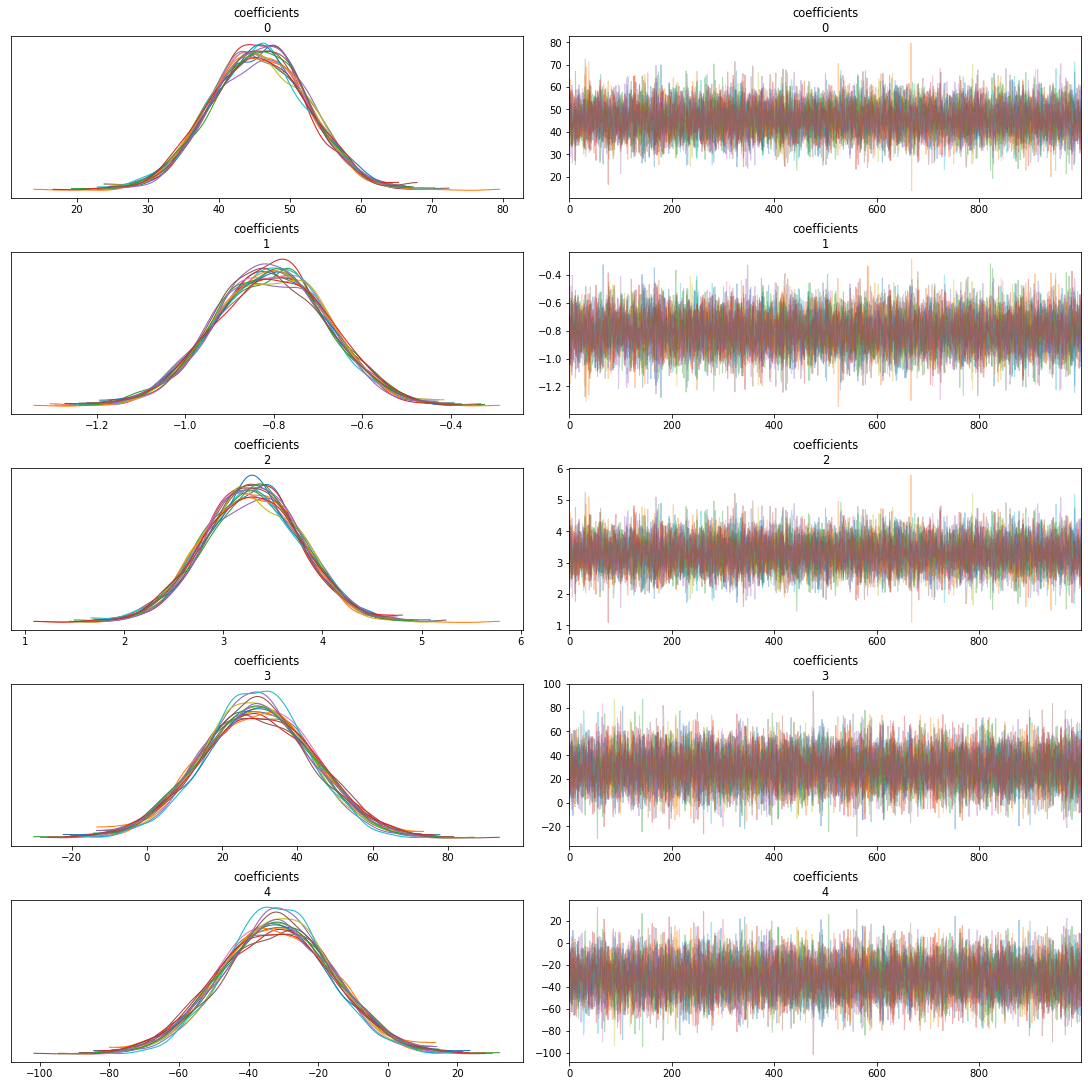

In [65]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=False, figsize=(15, 15));

In [20]:
samples_1 = mcmc.get_samples()
samples = np.array(samples_1["coefficients"]).ravel()
samples, samples.shape

(array([0.48596452, 0.48596452, 0.44689322, ..., 0.39463736, 0.39463736, 0.39463736]),
 (160000,))

In [21]:
df, loc, scale = stats.t.fit(samples)
df, loc, scale

(297.44648909267323, 0.44455961172283265, 0.13936863120428605)